In [1]:
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

%matplotlib inline

In [2]:
# Insert dataset in data loaders
img_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 100

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
# MLP Encoder and Decoder

mlp_enc_outs  = 512
z_dim         = 20

class MLP_Encode(nn.Module):
    def __init__(self):
        """
        Initialize encoder model. MLP architecture here.
        """
        super(MLP_Encode, self).__init__()

        # Inputs are of size 28 * 28 = 784
        self.fc     = nn.Linear(784, mlp_enc_outs)
        self.relu   = nn.ReLU()

        # mu and log variance layers
        self.fc_mu  = nn.Linear(mlp_enc_outs, z_dim)
        self.fc_var = nn.Linear(mlp_enc_outs, z_dim)

    def forward(self, x):
        """
        Apply encoder transformation. Return mu and logvar.
        """
        out     = self.fc(x)
        out     = self.relu(out)
        out_mu  = self.fc_mu(out)
        out_var = self.fc_var(out)

        return out_mu, out_var

class MLP_Decode(nn.Module):
    def __init__(self):
        """
        Initialize decoder model. MLP architecture here.
        """
        super(MLP_Decode, self).__init__()

        # Outputs are of size 28 * 28 = 784
        self.fc1  = nn.Linear(z_dim, mlp_enc_outs)
        self.relu = nn.ReLU()
        self.fc2  = nn.Linear(mlp_enc_outs, 784)
        self.sig  = nn.Sigmoid()

    def forward(self, x):
        """
        Apply decoder transformation.
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sig(out)

        return out

In [4]:
# MLP Encoder and Decoder

mlp_enc_outs  = 512
z_dim         = 20

class CNN_Encode(nn.Module):
    def __init__(self):
        """
        Initialize encoder model. CNN architecture here.
        """
        super(CNN_Encode, self).__init__()

        # Inputs are of size 28 * 28 = 784
        self.cv1    = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.cv2    = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.relu   = nn.ReLU()

        # mu and log variance layers
        self.fc_mu  = nn.Linear(256*7*7, z_dim)
        self.fc_var = nn.Linear(256*7*7, z_dim)

    def forward(self, x):
        """
        Apply encoder transformation. Return mu and logvar.
        """
        out     = self.cv1(x)
        out     = self.relu(out)
        out     = self.cv2(out)
        out     = self.relu(out)

        # Flatten layer
        out     = out.view(out.size(0), -1)

        out_mu  = self.fc_mu(out)
        out_var = self.fc_var(out)

        return out_mu, out_var

class CNN_Decode(nn.Module):
    def __init__(self):
        """
        Initialize decoder model. CNN architecture here.
        Steps basically reverse prior encoder.
        """
        super(CNN_Decode, self).__init__()

        # Outputs are of size 28 * 28 = 784
        self.fc1  = nn.Linear(z_dim, 256*7*7)
        self.relu = nn.ReLU()
        self.cv2  = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.cv1  = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.sig  = nn.Sigmoid()

    def forward(self, x):
        """
        Apply decoder transformation.
        """
        out = self.fc1(x)

        # Unflatten layer
        out = out.view(out.size(0), 256, 7, 7)
        out = self.cv2(out)
        out = self.relu(out)
        out = self.cv1(out)
        out = self.sig(out)

        return out

In [5]:
# VAE model

class VAE(nn.Module):
    def __init__(self):
        """
        Initialize decoder and encoder depending on MLP or CNN.
        """
        super(VAE, self).__init__()

        self.encode = CNN_Encode()
        self.decode = CNN_Decode()

    def reparameterization(self, x):
        """
        Function for reparameterization trick as explained here.
        """
        # Step 1: push x through encoder
        mu, logvar = self.encode(x)

        # Step 2: sample noise, reparameterize
        var     = torch.exp(torch.mul(0.5, logvar))
        samples = torch.rand_like(var).cuda()
        full    = mu + var * samples

        # Step 3: push result through decoder
        dec     = self.decode(full)

        return dec, mu, logvar

    def forward(self, x):
        """
        Putting it all together.
        """
        out, mu, var = self.reparameterization(x)

        return out, mu, var

In [6]:
# Cell for loss function definition

def loss_function(x, x_recon, mu, logvar):
    """
    Calculate loss according to equation from q7.
    """
    # KL Divergence term
    L_reg   = (1/2) * torch.sum(mu**2 + torch.exp(logvar) - 1 - logvar)

    # Reconstruction term
    # We use binary cross entropy loss since p(x | z) models a multivariate factorized Bernoulli distribution
    L_recon = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')

    L = L_recon + L_reg

    return L 

In [7]:
# Training cell
model = VAE()

if (torch.cuda.is_available()):
    model.cuda()
    print("Using GPU.")
else:
    print("Using CPU.")

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model.train()

for epoch in range(80):
    full_loss   = 0

    for index, (data, target) in enumerate(train_dataloader):

        # Move to GPU
        new_data, new_target = data.cuda(), target.cuda()

        # For MLP
        # new_data = new_data.view(batch_size, 784)

        optimizer.zero_grad()

        # Reconstruction
        recon, mu, logvar = model(new_data)

        # Compute loss
        loss = loss_function(new_data, recon, mu, logvar)
        full_loss = full_loss + loss.item()

        # Backprop
        loss.backward()
        optimizer.step()

        if index % 100 == 0 and index != 0:
            print('--> Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, index * len(new_data), len(train_dataloader.dataset),
                  100. * index / len(train_dataloader), full_loss / (index * batch_size)))
            
    scheduler.step()

    print("Train Epoch {}: average loss {}\n".format(epoch, full_loss / (index * batch_size)))

Using GPU.
--> Train Epoch: 0 [10000/60000 (17%)]	Loss: 1078.343532
--> Train Epoch: 0 [20000/60000 (33%)]	Loss: 628.784466
--> Train Epoch: 0 [30000/60000 (50%)]	Loss: 461.035598
--> Train Epoch: 0 [40000/60000 (67%)]	Loss: 373.300140
--> Train Epoch: 0 [50000/60000 (83%)]	Loss: 319.378913
Train Epoch 0: average loss 283.07816841545804

--> Train Epoch: 1 [10000/60000 (17%)]	Loss: 98.080187
--> Train Epoch: 1 [20000/60000 (33%)]	Loss: 97.162248
--> Train Epoch: 1 [30000/60000 (50%)]	Loss: 96.241012
--> Train Epoch: 1 [40000/60000 (67%)]	Loss: 95.668086
--> Train Epoch: 1 [50000/60000 (83%)]	Loss: 95.128721
Train Epoch 1: average loss 94.70267529215359

--> Train Epoch: 2 [10000/60000 (17%)]	Loss: 91.809841
--> Train Epoch: 2 [20000/60000 (33%)]	Loss: 91.791388
--> Train Epoch: 2 [30000/60000 (50%)]	Loss: 91.421165
--> Train Epoch: 2 [40000/60000 (67%)]	Loss: 91.278670
--> Train Epoch: 2 [50000/60000 (83%)]	Loss: 91.044869
Train Epoch 2: average loss 90.93011118791736

--> Train Epoch:

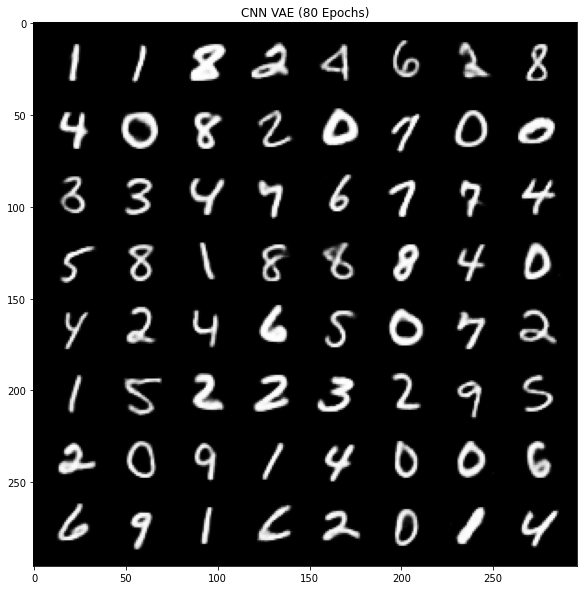

In [8]:
# Evaluate model

model.eval()

def imshow(img):
    # unnormalize
    img = img.clamp(0, 1)
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title('CNN VAE (80 Epochs)')
    plt.show()
    fig.savefig('example.png', dpi = 300)

# get some random training images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

with torch.no_grad():
    images      = images.cuda()
    # For MLP:
    # new_im      = images.view(-1, 784)
    # outs, _, _  = model(new_im)
    outs, _, _  = model(images)
    outs        = outs.cpu()
    outs        = torch.reshape(outs, images.shape)
    imshow(torchvision.utils.make_grid(outs[:64], 8, 8))